In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

if 'KERAS_BACKEND' not in os.environ:
    os.environ['KERAS_BACKEND'] = 'tensorflow'

In [19]:
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt
import seaborn as sns

# Principle Bayesian Workflow for Cognitive Modeling with SSMS and BayesFlow

 In this tutorial, we demonstrate a [principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) for developing and applying cognitive models with Amortized Bayesian Inference (ABI). We use Sequential Sampling Models (SSMs) to represent and simulate a cognitive process. The simulation is given by the [Sequential Sampling Model Simulators (SSMS)](https://lnccbrown.github.io/ssm-simulators/api/ssms/) package, the backbone for the [Hierarchical Sequential Sampling Model (HSSM) toolbox](https://lnccbrown.github.io/HSSM/). We use [BayesFlow](https://bayesflow.org)'s powerful generative neural networks and comprehensive diagnostics utilities to train on the simulated data and estimate model parameters.

## Simulator

We start with the basic simulator from the HSSM toolbox. We start with the simplest simulator available: the classic drift-diffusion model (DDM) with 4 parameters:

* Drift rate ($v$),
* Boundary ($a$),
* Initial bias ($z$), and
* Non-decision time ($t$).

These are the parameters that we sample as priors (to be specified below) and used as inputs. For each sampled parameters, we specify $N$ samples for the simulation. The resulting collection of reaction times (RTs) and choices are our simulation outputs. These outputs are used as our dataset for training and validating the neural approximator.

In [7]:
from ssms.basic_simulators.simulator import simulator as ssm_sim

In [8]:
def ddm_simulator(
        v=None, a=None, z=None, t=None,
        n_samples: int=100
):
    
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=t), n_samples=n_samples)

    rts = ddm_sim['rts'].astype(np.float32)
    choices = ddm_sim['choices'].astype(np.float32)

    return dict(rts=rts, choices=choices)

In [12]:
sim = ddm_simulator(v=0.5, a=1.0, z=0.5, t=0.7)
print(sim['rts'].shape)
print(sim['choices'].shape)

(100, 1)
(100, 1)


## Priors

Next, we will sample the DDM parameters from our simulator as priors from some distributions. Below, we specify the prior distributions:

\begin{equation}
v \sim \mathrm{Gamma}(2, 0.8), \; a \sim \mathrm{Gamma}(10, 0.2), \; z \sim \mathrm{Beta}(2, 2), \; t \sim \mathrm{Gamma}(1.5, 0.2).
\end{equation}

In [9]:
def priors(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(2, 2)
    ndt = rng.gamma(1.5, 0.2)

    return dict(v=drift, a=threshold, z=bias, t=ndt)

We can inspect the sampled parameters as a dictionary.

In [11]:
theta = priors()
theta

{'v': 1.742037588049028,
 'a': 3.2617158633304886,
 'z': 0.25698519214465626,
 't': 0.0305145176690944}

## Putting everything together

After specifying the simulator and priors, we would wrap them together using BayesFlow's `make_simulator` function. Under the hood, BayesFlow unpacks the dictionary of samples from `priors` and uses them as inputs for the `ddm_simulator`.

In [13]:
simulator = bf.make_simulator([priors, ddm_simulator])

Once we have the `simulator`, we can specify a batch size and use it to generate samples, just like what we did from `ddm_simulator` itself.

In [43]:
batch_size = 10
draws = simulator.sample(batch_size=batch_size)

The sample draws consists of both the simulator outputs from `ddm_simulator` and the prior samples from `priors`. Because we specified a batch size, the draws would have shapes `(batch_size, [shape_of_samples])`.

In [44]:
print(draws['v'].shape)
print(draws['t'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(10, 1)
(10, 1)
(10, 100, 1)
(10, 100, 1)


## Prior Predictive Checks

To make sure that we are sampling the priors properly, BayesFlow has a pretty nice visual inspection in its `diagnostics` module that allows us to observe the samples directly as the respective sample distribution for each parameter.

In [45]:
prior_samples = simulator.simulators[0].sample(500)

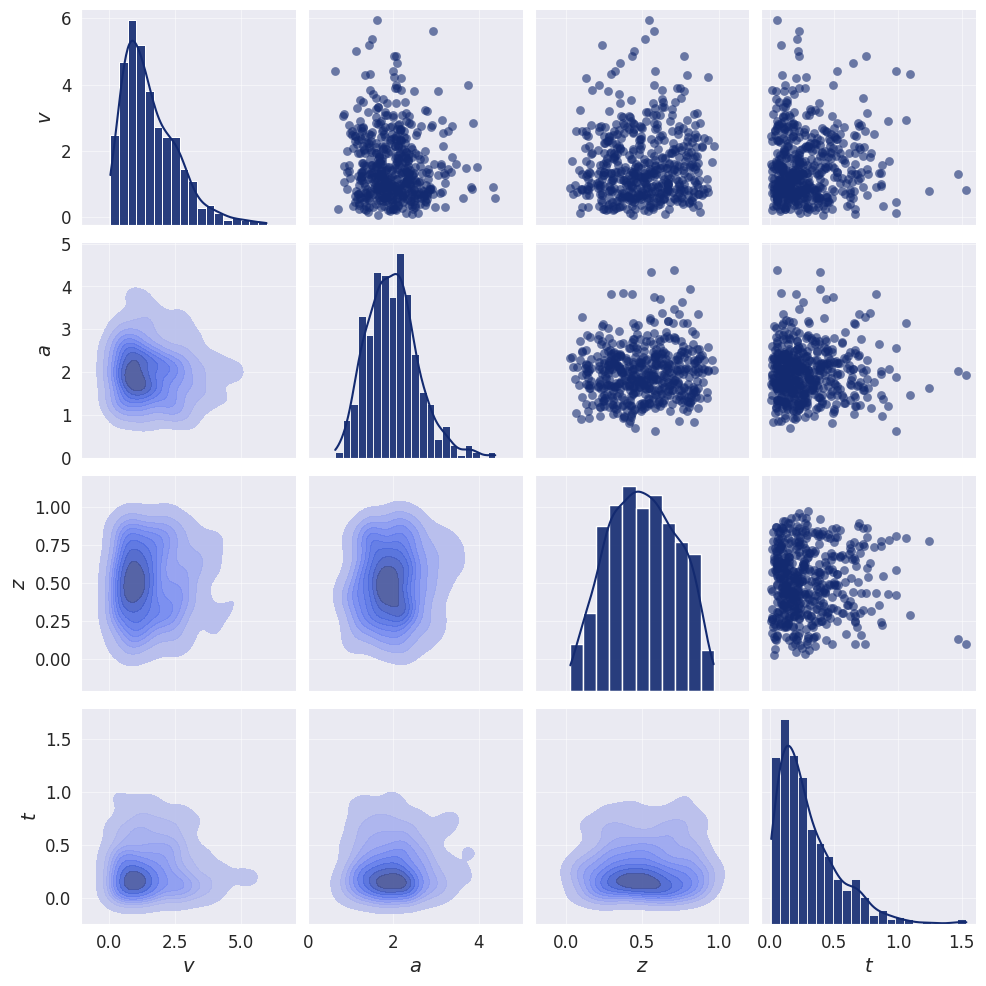

In [46]:
prior_grid = bf.diagnostics.plots.pairs_samples(
    samples=prior_samples, variable_names=[r'$v$', r'$a$', r'$z$', r'$t$']
)

## Prior Pushforward Checks

Furthermore, to ensure that the simulator produces reliable results, we can also visualize the outputs from `simulator` samples by their individual draw.

In [47]:
n_rows = 2
n_cols = batch_size // n_rows
print(n_rows, n_cols)

2 5


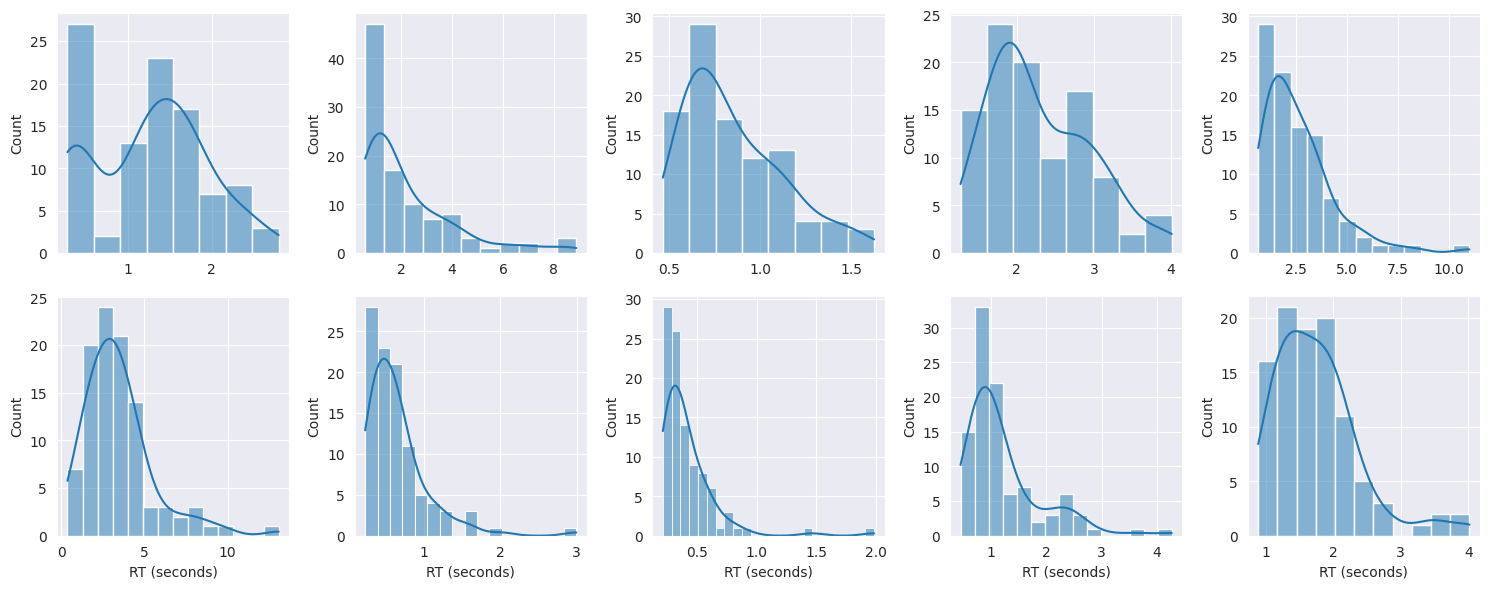

In [48]:
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6))

for i, a in enumerate(ax.flat):
    ax = sns.histplot(data=draws['rts'][i], ax=a, legend=False, kde=True)
    if i > n_cols - 1:
        ax.set_xlabel("RT (seconds)")
fig.tight_layout()

## Adapter

To make sure that the simulated data and priors all friendly to the neural approximator, we use BayesFlow's `Adapter` to transform the data into summary variables and inference variables.

In a nutshell, from the perspective of the neural estimator:

* **Summary variables** are simulated data, and
* **Inference variables** are the parameters.

In [50]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .standardize()
    .concatenate(['v', 'a', 'z', 't'], into="inference_variables")
    .concatenate(['rts', 'choices'], into="summary_variables")
)

Here is what the individual elements in `adapter` means:

* `.convert_dtype()` converts all samples to a data type that the neural estimator likes. Typically, this is `float32`.
* `.standardize()` ensures that the samples are standardized so that the neural estimator can reliably learn them without introducing exploding or vanishing gradients.
* `.concatenate()` bundles the sampled parameters together as `inference_variables`, and the simulated response times and choices as `summary_variables`.

Below, we can visualize the `adapter` workflow to make the data preprocessing steps transparent.

In [51]:
adapter

Adapter([0: ConvertDType -> 1: Standardize -> 2: Concatenate(['v', 'a', 'z', 't'] -> 'inference_variables') -> 3: Concatenate(['rts', 'choices'] -> 'summary_variables')])

We can inspect the transformed data after wrapping the simulation in the adapter to process.

In [54]:
adapted_draws = adapter(simulator.sample(10))

In [59]:
# This step makes sure that the samples are bundled properly as summary variables and inference variables
print(adapted_draws['summary_variables'].shape)
print(adapted_draws['inference_variables'].shape)

(10, 100, 2)
(10, 4)


## Neural estimator

The neural estimator is essentially a two-stage generative neural network consisting of a **summary network** and an **inference network**.

* **Summary network** takes the simulated data (*summary variables*) directly as inputs, and compress it into some latent summary statistics,
* **Inference network** takes the summary statistics as inputs, and infers the parameters (*inference variables*) from them.

### Summary Network

Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. Exchangeability in data means that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. In other words, the data is permutation invariant. For that, we will use a `SetTransformer` which does exactly that (a `DeepSet` is a cheaper version for simpler problems).

This network will take (at least) 3D tensors of shape `(batch_size, num_obs, D)` and reduce them to 2D tensors of shape `(batch_size, summary_dim)`, where `summary_dim` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a permutation-invariant network with `summary_dim = 32`:

In [60]:
summary_net = bf.networks.SetTransformer(summary_dim=32)

### Inference Network

To actually approximate the posterior distribution, we need to define a generative neural network. Here we choose a [Flow Matching](https://arxiv.org/abs/2210.02747) network via `bf.networks.FlowMatching()`.

In [61]:
inference_net = bf.networks.FlowMatching()

## Workflow

BayesFlow makes everything easier by wrapping the entire amortization process into a `Workflow` object. Here, we can simply use a `BasicWorkflow` object that bring together the simulator, the adapter, the summary network, and the inference network.

In [62]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

As you can see, simulating offline dataset becomes speedy. With GPU, this becomes blazing fast.

In [63]:
%%time 
_ = workflow.simulate(32)

CPU times: user 214 ms, sys: 7.95 ms, total: 222 ms
Wall time: 220 ms


## Training

Using the `BasicWorkflow` object, we can generate training data and validation data for training the neural estimator.

In [81]:
training_data = workflow.simulate(5000)
validation_data = workflow.simulate(300)

In [82]:
history = workflow.fit_offline(
    data=training_data,
    epochs=50,
    batch_size=32,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - loss: 4.0875 - loss/inference_loss: 4.0875 - val_loss: 1.3248 - val_loss/inference_loss: 1.3248
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 1.5052 - loss/inference_loss: 1.5052 - val_loss: 1.0489 - val_loss/inference_loss: 1.0489
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 1.2106 - loss/inference_loss: 1.2106 - val_loss: 0.7171 - val_loss/inference_loss: 0.7171
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 1.0913 - loss/inference_loss: 1.0913 - val_loss: 0.8540 - val_loss/inference_loss: 0.8540
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 1.0152 - loss/inference_loss: 1.0152 - val_loss: 0.8190 - val_loss/inference_loss: 0.8190
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 0.9443 - loss/inference_loss: 0.9443 - val_loss: 1.0401 - val_loss/inference_loss: 1.0401
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.8672 - loss/infer

## Diagnostics

The `Workflow` object also gather all the diagnostics functionality that BayesFlow has to offer.

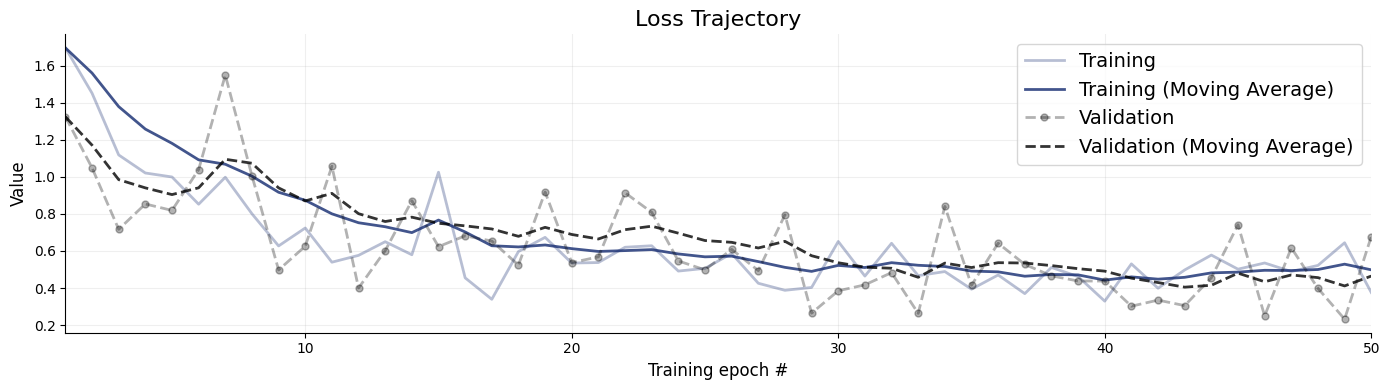

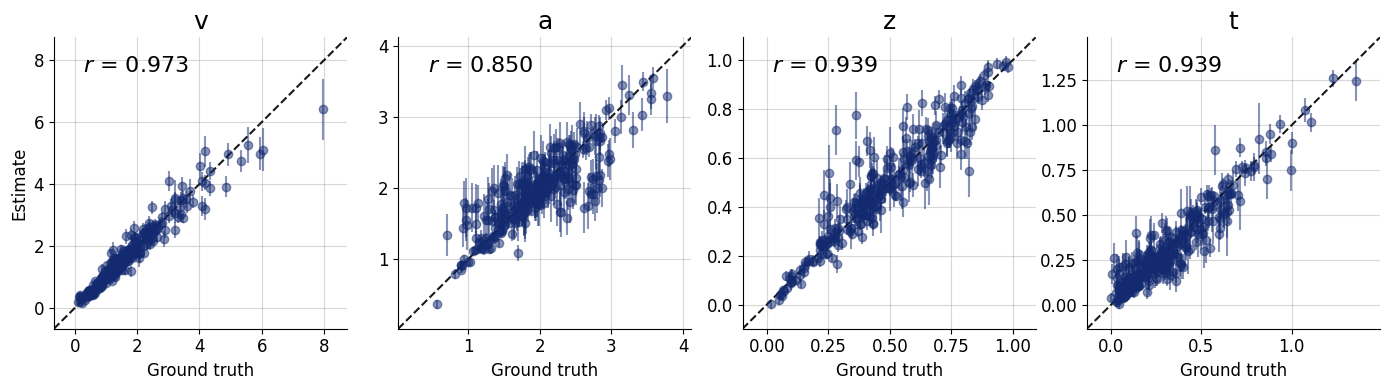

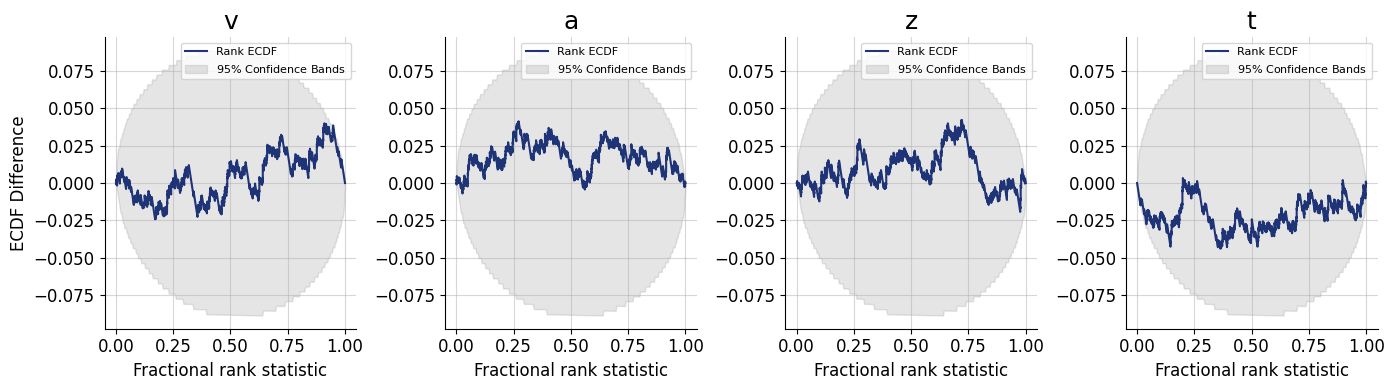

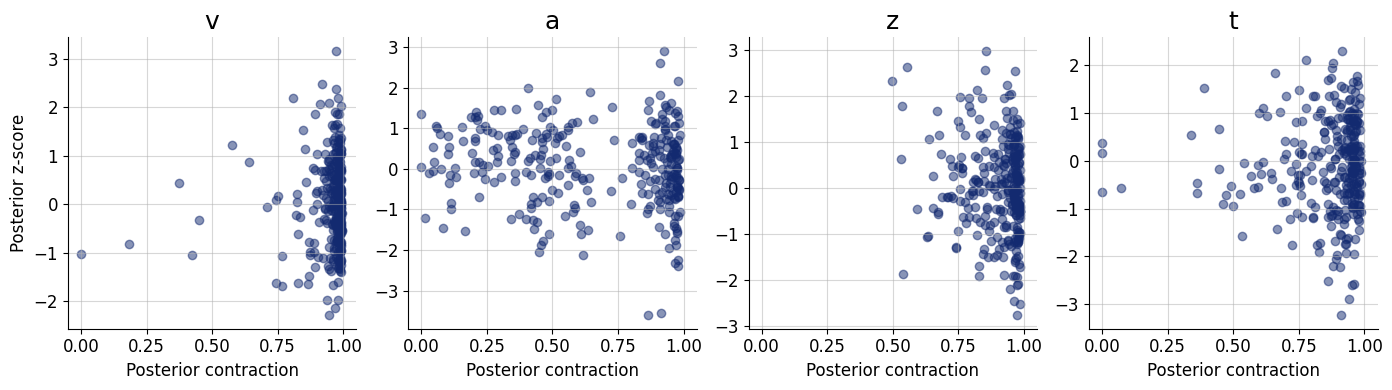

In [83]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    recovery_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (14, 4), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (14, 4), "label_fontsize": 12}    
)

*Here, we describe what each of these plots means. From top to bottom:

1) **Loss Trajectory** records the training and validation losses per epoch for the neural estimator.
2) **Parameter Recovery** gives us a sense of whether the distribution from the generated posterior samples from the neural estimator is in agreement with the ground truth from the simulated dataset. This indicates the *global inferential accuracy* of the neural estimator.
3) **Rank ECDF** plots the expected cumulative distribution function (ECDF) for the rank statistics of the parameter samples. For a well-calibrated neural estimator, this function should fall entirely within the 95\% confidence bands for all parameters. For more detail, please take a look at [this paper about simulation-based calibration (SBC)](https://arxiv.org/abs/2103.10522).
4) **$z$-score contraction** does a similar job as parameter recovery in a sense that it tells us how well the posterior estimation is from the true parameter. For more detail, please take a look at [this page](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html)

**Congrats!** Now you have learned about the workflow from simulation to estimation through the inter-working between the SSM Simulator and BayesFlow!

## The Spicier Stuff: Model Comparison (maybe)?

**To be continued ...**